In [ ]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

In [4]:
# Download latest version
path = kagglehub.dataset_download("sooyoungher/smoking-drinking-dataset")
print("Path to dataset files:", path)

file_name = "smoking_driking_dataset_Ver01.csv"
file_path = f"{path}/{file_name}"
df = pd.read_csv(file_path)

Path to dataset files: C:\Users\umbeg\.cache\kagglehub\datasets\sooyoungher\smoking-drinking-dataset\versions\2


In [5]:
df.columns

Index(['sex', 'age', 'height', 'weight', 'waistline', 'sight_left',
       'sight_right', 'hear_left', 'hear_right', 'SBP', 'DBP', 'BLDS',
       'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin',
       'urine_protein', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT',
       'gamma_GTP', 'SMK_stat_type_cd', 'DRK_YN'],
      dtype='object')

# Feature Engineering

## Anthropometric Features

In [6]:
df['BMI'] = df['weight'] / (df['height'] / 100) ** 2                     # Use to assess overall obesity.
df['wth_ratio'] = df['waistline'] / df['height']                         # A good indicator of central (abdominal) obesity and cardiovascular risk.
df['wtw_ratio'] = df['waistline'] / df['weight']                         # May provide additional insights into fat distribution.
df['obesity_flag'] = (df['BMI'] >= 30).astype(int)

## Cardiovascular Features

In [7]:
def bp_category(row):
    if row['SBP'] < 120 and row['DBP'] < 80:
        return 'Normal'
    elif row['SBP'] < 140 and row['DBP'] < 90:
        return 'Prehypertensive'
    else:
        return 'Hypertensive'

df['pulse_pressure'] = df['SBP'] - df['DBP']                             # High pulse pressure is linked to arterial stiffness and cardiovascular risk.
df['MAP'] = (2 * df['DBP'] + df['SBP']) / 3
df['bp_category'] = df.apply(bp_category, axis=1)


## Lipid Profile & Metabolic Ratios


In [8]:
df['TC_HDL_ratio'] = df['tot_chole'] / df['HDL_chole']                   # Widely used to assess cardiovascular risk.
df['LDL_HDL_ratio'] = df['LDL_chole'] / df['HDL_chole']                              
df['non_HDL_chole'] = df['tot_chole'] - df['HDL_chole']                  # Represents the atherogenic (bad) cholesterol particles.
df['triglyceride_hdl_ratio'] = df['triglyceride'] / df['HDL_chole']      

df["AIP"] = np.log10(df['triglyceride'] / df['HDL_chole'])               # Atherogenic index of plasma.
df['TyG'] = np.log(df['triglyceride'] * df['BLDS'] / 2)                   

## Liver and Kidney Function Features

In [9]:
def calc_eGFR(row):
    # Using the CKD-EPI formula from 2009
    # https://doi.org/10.7326/0003-4819-150-9-200905050-00006

    SCr = row['serum_creatinine']
    age = row['age']
    is_female = row['sex'] == 'Female'
    
    k = 0.7 if is_female else 0.9
    a = -0.329 if is_female else -0.411

    eGFR = 141 * min(SCr / k, 1) ** a * max(SCr / k, 1) ** (-1.209) * 0.993 ** age
    eGFR *= 1.018 if is_female else 1

    return eGFR

df['AST_ALT_ratio'] = df['SGOT_AST'] / df['SGOT_ALT']                    # Can help in differentiating types of liver disease (for example, a high ratio might indicate alcoholic liver disease).
df['liver_enzyme_interaction'] = df['gamma_GTP'] * df['SGOT_AST']
df['liver_enzyme_avg'] = (df['SGOT_AST'] + df['SGOT_ALT'] + df['gamma_GTP']) / 3
df['eGFR'] = df.apply(calc_eGFR, axis=1)

# Model Performance

In [10]:
label_encoders = {}

for column in df.columns:
    if df[column].dtype == 'object':
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])


In [11]:
# Calculate Z-scores
z_scores = np.abs(stats.zscore(df.select_dtypes(include=['number'])))

# Set a threshold for Z-scores
threshold = 5

# Filter out rows with Z-scores above the threshold
df_no_outliers = df[(z_scores < threshold).all(axis=1)]

# Print the number of rows removed
print(f"Number of rows removed: {len(df) - len(df_no_outliers)}")

df = df_no_outliers

Number of rows removed: 79322


In [12]:
df.head()

sex  age  height  weight  waistline  sight_left  sight_right  hear_left  \
0    1   35     170      75       90.0         1.0          1.0        1.0   
1    1   30     180      80       89.0         0.9          1.2        1.0   
2    1   40     165      75       91.0         1.2          1.5        1.0   
3    1   50     175      80       91.0         1.5          1.2        1.0   
4    1   50     165      60       80.0         1.0          1.2        1.0   

   hear_right    SBP  ...  TC_HDL_ratio  LDL_HDL_ratio  non_HDL_chole  \
0         1.0  120.0  ...      4.020833       2.625000          145.0   
1         1.0  130.0  ...      4.145455       2.690909          173.0   
2         1.0  120.0  ...      3.317073       1.804878           95.0   
3         1.0  145.0  ...      2.644737       1.368421          125.0   
4         1.0  138.0  ...      3.262295       1.918033          138.0   

   triglyceride_hdl_ratio       AIP       TyG  AST_ALT_ratio  \
0                1.916667  0.282547  8.423761       0.600000   
1                2.200000  0.342423  8.766082       0.555556   
2                2.536585  0.404249  8.536211       1.468750   
3                1.394737  0.144492  8.524169       0.852941   
4                1.704918  0.231704  8.566364       1.583333   

   liver_enzyme_interaction  liver_enzyme_avg        eGFR  
0                     840.0         32.000000   97.078265  
1                     540.0         27.666667  114.208011  
2                    3196.0         49.000000  106.460635  
3                     522.0         27.000000   77.860462  
4                     475.0         18.666667  104.161020  

[5 rows x 41 columns]

In [ ]:
df_smoke_first_step = df.drop(['DRK_YN'], axis=1)

In [ ]:
df_smoke_first_step.head()

sex  age  height  weight  waistline  sight_left  sight_right  hear_left  \
0    1   35     170      75       90.0         1.0          1.0        1.0   
1    1   30     180      80       89.0         0.9          1.2        1.0   
2    1   40     165      75       91.0         1.2          1.5        1.0   
3    1   50     175      80       91.0         1.5          1.2        1.0   
4    1   50     165      60       80.0         1.0          1.2        1.0   

   hear_right    SBP  ...  TC_HDL_ratio  LDL_HDL_ratio  non_HDL_chole  \
0         1.0  120.0  ...      4.020833       2.625000          145.0   
1         1.0  130.0  ...      4.145455       2.690909          173.0   
2         1.0  120.0  ...      3.317073       1.804878           95.0   
3         1.0  145.0  ...      2.644737       1.368421          125.0   
4         1.0  138.0  ...      3.262295       1.918033          138.0   

   triglyceride_hdl_ratio       AIP       TyG  AST_ALT_ratio  \
0                1.916667  0.282547  8.423761       0.600000   
1                2.200000  0.342423  8.766082       0.555556   
2                2.536585  0.404249  8.536211       1.468750   
3                1.394737  0.144492  8.524169       0.852941   
4                1.704918  0.231704  8.566364       1.583333   

   liver_enzyme_interaction  liver_enzyme_avg        eGFR  
0                     840.0         32.000000   97.078265  
1                     540.0         27.666667  114.208011  
2                    3196.0         49.000000  106.460635  
3                     522.0         27.000000   77.860462  
4                     475.0         18.666667  104.161020  

[5 rows x 40 columns]

In [ ]:
X_smoke = df_smoke_first_step.drop(['SMK_stat_type_cd'], axis=1)
y_smoke = df_smoke_first_step['SMK_stat_type_cd']

In [ ]:
y_smoke_first_step = (y_smoke > 1).astype(int)

In [ ]:
X_sample, X_test, y_sample, y_test = train_test_split(X_smoke, y_smoke_first_step, train_size=0.1, random_state=42, stratify=y_smoke_first_step)

In [23]:
scaler = StandardScaler()

X_sample = scaler.fit_transform(X_sample)

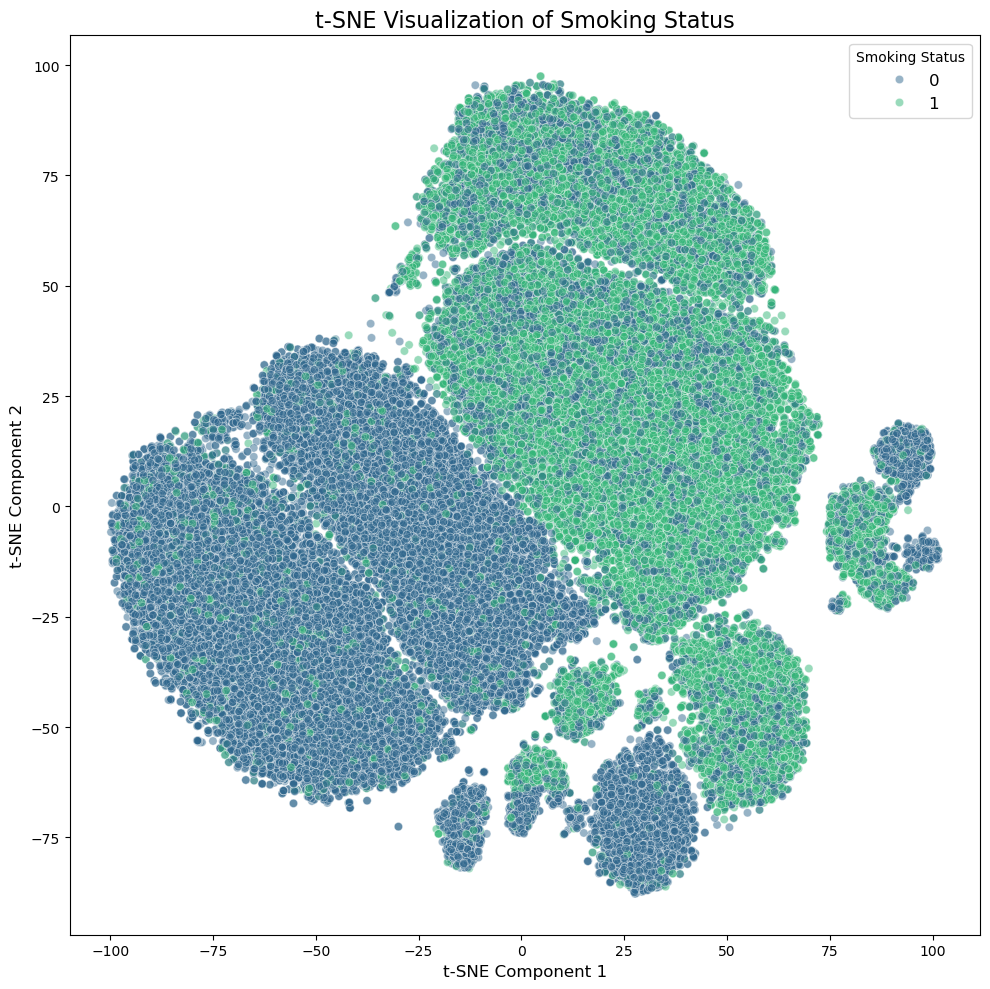

In [ ]:
tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)

X_tsne = tsne.fit_transform(X_sample)

plt.figure(figsize=(10, 10))

sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_sample, palette='viridis', alpha=0.5)

plt.title('t-SNE Visualization of Smoking Status', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.legend(title='Smoking Status', fontsize=12)
plt.tight_layout()
plt.show()

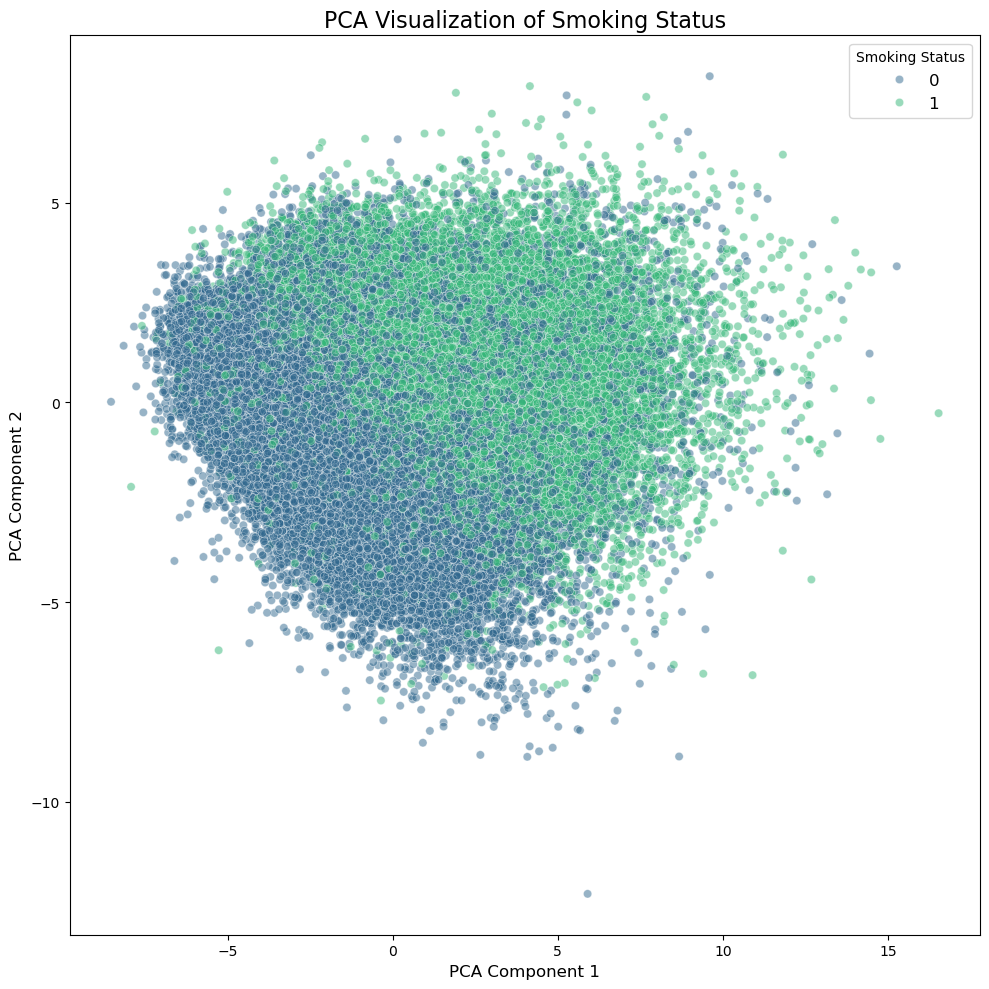

In [ ]:
pca = PCA(n_components=2, random_state=42)

X_pca = pca.fit_transform(X_sample)

plt.figure(figsize=(10, 10))

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_sample, palette='viridis', alpha=0.5)

plt.title('PCA Visualization of Smoking Status', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.legend(title='Smoking Status', fontsize=12)
plt.tight_layout()
plt.show()

In [16]:
df_smoke_second_step = df[df['SMK_stat_type_cd'] != 1].drop(['DRK_YN'], axis=1)
df_smoke_second_step['SMK_stat_type_cd'] = df_smoke_second_step['SMK_stat_type_cd'].map({2: 0, 3: 1})

In [18]:
X_smoke = df_smoke_second_step.drop(['SMK_stat_type_cd'], axis=1)
y_smoke = df_smoke_second_step['SMK_stat_type_cd']

In [29]:
X_sample, X_test, y_sample, y_test = train_test_split(X_smoke, y_smoke, train_size=0.1, random_state=42, stratify=y_smoke)

In [30]:
scaler = StandardScaler()

X_sample = scaler.fit_transform(X_sample)

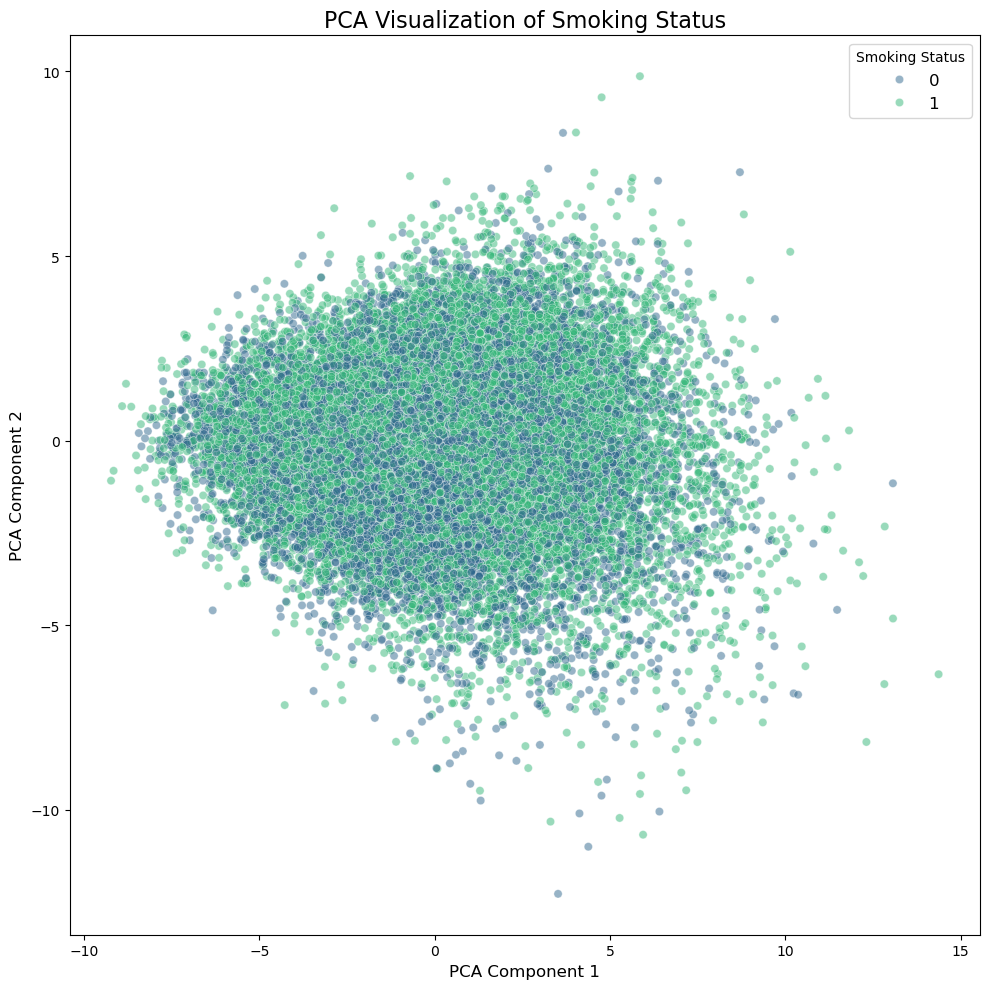

In [ ]:
pca = PCA(n_components=2, random_state=42)

X_pca = pca.fit_transform(X_sample)

plt.figure(figsize=(10, 10))

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_sample, palette='viridis', alpha=0.5)

plt.title('PCA Visualization of Smoking Status', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.legend(title='Smoking Status', fontsize=12)
plt.tight_layout()
plt.show()

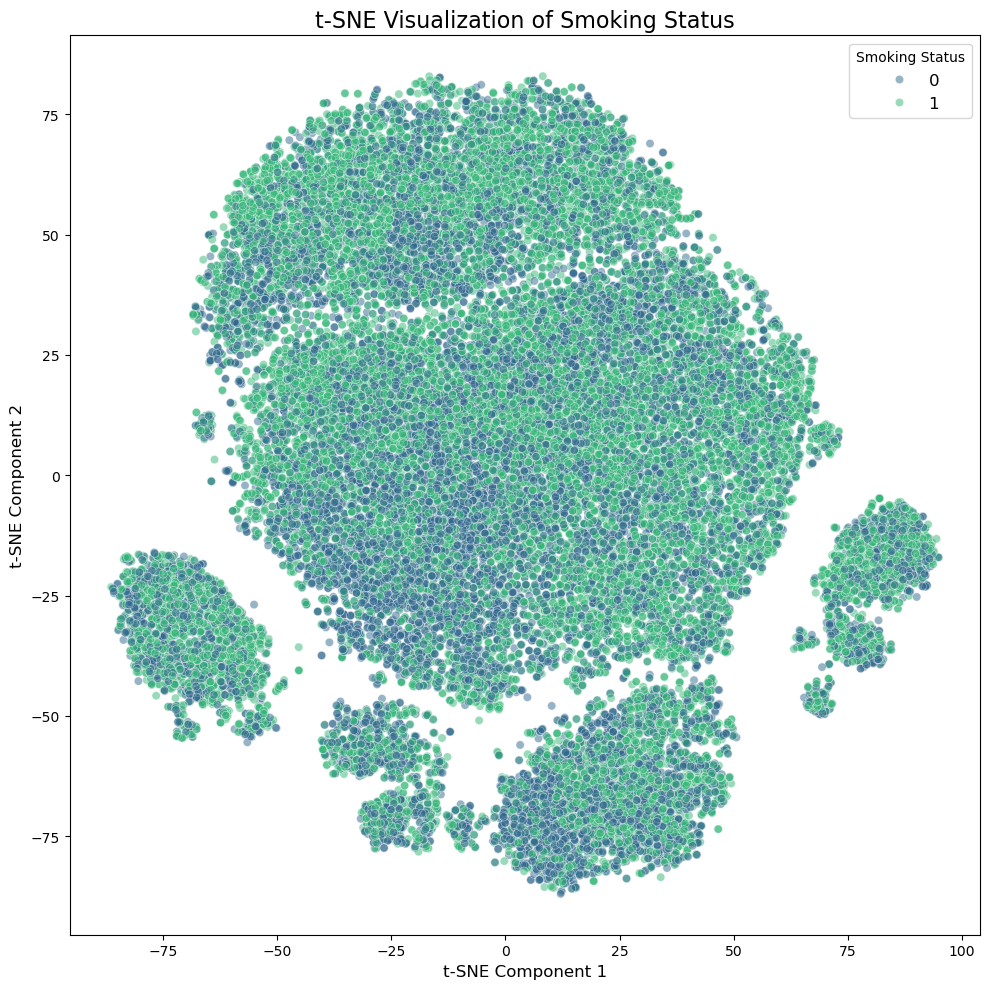

In [ ]:
tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)

X_tsne = tsne.fit_transform(X_sample)

plt.figure(figsize=(10, 10))

sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_sample, palette='viridis', alpha=0.5)

plt.title('t-SNE Visualization of Smoking Status', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.legend(title='Smoking Status', fontsize=12)
plt.tight_layout()
plt.show()